# Dataset and references from:
https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline

In [2]:
train_set = pd.read_csv('train_E6oV3lV.csv')
test_set = pd.read_csv('test_tweets_anuFYb8.csv')
train_set.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Data Cleaning
We can see from the training set that there are 3 columns, label is the dependant variable column (output). The twitter handles (@user) are of no use to us since they don't contribute to the output, so we will remove them. Various data preprocessing steps we will need to perform are:
* Stopword removal (removing filler or unnecessary words)
* Removal of punctuations, numbers and special characters
* Lemmatization or Stemming (whichever give better output)

In [3]:
# Combining train_set and test_set so we don't have to perform same preprocessing operations twice
combined_set = train_set.append(test_set, ignore_index = True, sort = True)
type(combined_set)

pandas.core.frame.DataFrame

In [4]:
#Provide input text, remove unwanted text patterns
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, ' ', input_txt)
    return input_txt

In [5]:
#Create a new column with removed twitter handles
#Pick all words starting with @, and remove them using remove_pattern
combined_set['clean'] = np.vectorize(remove_pattern)(combined_set['tweet'], '@[\w]*')

In [6]:
#Removing Punctuations, Numbers and Special Characters
combined_set['clean'] =  combined_set['clean'].str.replace("[^a-zA-Z#]", " ")

In [7]:
#Removing words of length less than 3, for example 'hm' or 'oh'
combined_set['clean'] = combined_set['clean'].apply(lambda x:  ' '.join([w for w in x.split() if len(w) > 3]))

In [8]:
combined_set.head()

,id,label,tweet,clean
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


# Tokenization
Process of splitting words or sentences into tokens

In [9]:
tokenized_tweet = combined_set['clean'].apply(lambda x: x.split())
print(tokenized_tweet.head())
print(type(tokenized_tweet))

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean, dtype: object
<class 'pandas.core.series.Series'>


# Stemming
Stripping suffixes from a word

In [10]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: clean, dtype: object

# Lematization
Removing suffixes from a word so that the word keeps it's meaning

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
tokenized_tweet = lemmatizer.lemmatize(tokenized_tweet)

In [11]:
#Combining the words back to form sentences
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combined_set['clean'] = tokenized_tweet

# Visualization
### WordCloud
A wordcloud is a visualization where the most frequent words appear in large sizes and the less frequent words appear in smaller sizes

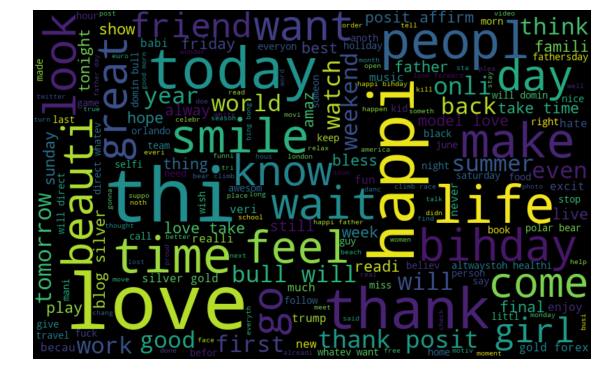

In [12]:
all_words = ' '.join([text for text in combined_set['clean']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

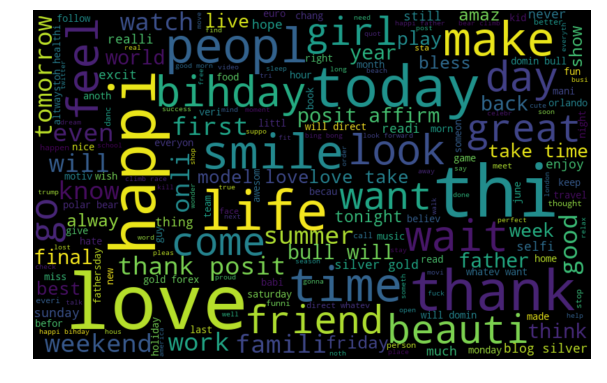

In [13]:
#Words from positive tweets
normal_words =' '.join([text for text in combined_set['clean'][combined_set['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

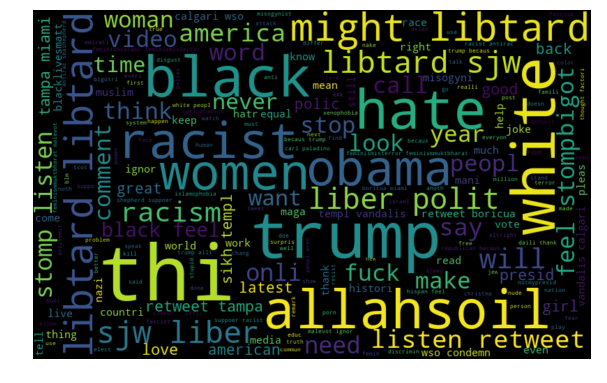

In [14]:
negative_words = ' '.join([text for text in combined_set['clean'][combined_set['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Even HashTags can denote positive sentiment or negative sentiment

In [15]:
#Store hashtag terms
def hashtag_extract(x):
    hashtags = []
    for i in x:
        hashtag = re.findall(r"#(\w+)",i)
        hashtags.append(hashtag)
    return hashtags

In [16]:
#extract positive hashtags from positive tweets
hashtag_regular = hashtag_extract(combined_set['clean'][combined_set['label'] == 0])
#extract negative hashtags from negative tweets
hashtag_negative = hashtag_extract(combined_set['clean'][combined_set['label'] == 1])

#unnest the list
hashtag_regular = sum(hashtag_regular, [])
hashtag_negative = sum(hashtag_negative, [])

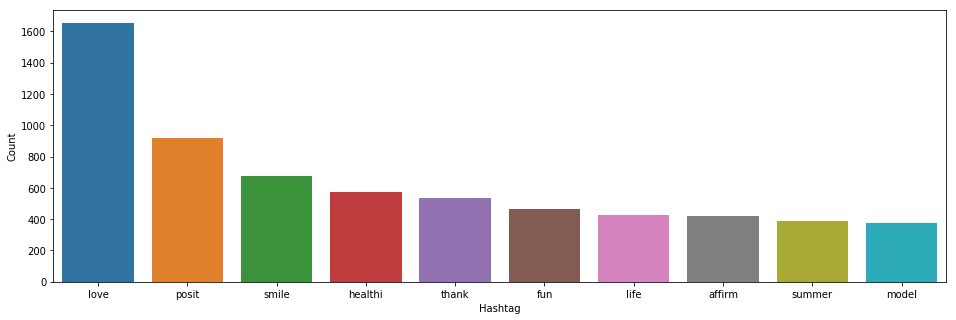

In [17]:
#Positive tweets
a = nltk.FreqDist(hashtag_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})

#selecting top 10 most frequent hashtags
d = d.nlargest(columns = "Count", n = 10)
plt.figure(figsize = (16,5))
axis = sns.barplot(data = d, x = "Hashtag", y = "Count")
axis.set(ylabel = 'Count')
plt.show()

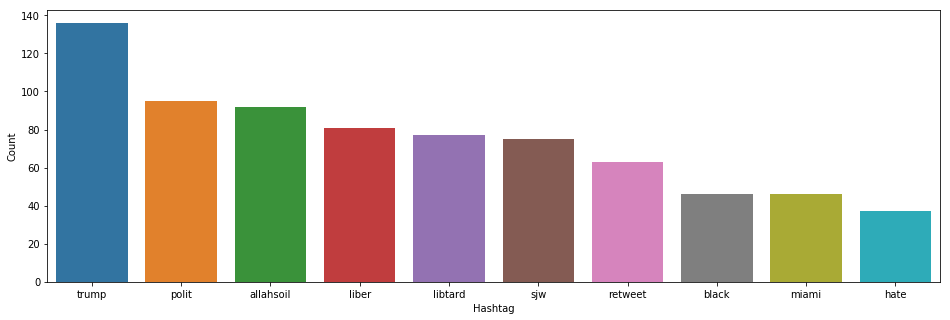

In [18]:
#Negative tweets
b = nltk.FreqDist(hashtag_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# Creating Bag of Words (BoW) model:

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
# Top 1000 words that appear a minimum of 2 times and remove words that appear 90% of the time
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combined_set['clean'])
bow.shape

(49159, 1000)

# TFIDF:
We will use TF-IDF ( Term Frequency - Inverse Document Frequency ) <br>
TF: Number of times a word appears in a document / total number of words in the document <br>
IDF: log ( total number of documents / number of documents with a certain word in it ) <br>
TF-IDF = TF * IDF <br>
TF-IDF takes into account not only the word of a single document but the word from the entire corpus

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Top 1000 words that appear a minimum of 2 times and remove words that appear 90% of the time
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combined_set['clean'])

# Building training model
We will use 3 different classifiers to see which one will give the highest accuracy:
    * Logistic Regression
    * Naive Bayes Classification
    * Support Vector Machine Classification

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_set['label'], random_state=0, test_size=0.3)

In [22]:
lreg = LogisticRegression()
lreg = lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1 = f1_score(yvalid, prediction_int) # calculating f1 score
acc = accuracy_score(yvalid, prediction_int)
cm = confusion_matrix(yvalid, prediction_int)
print (f1, '\n', acc, '\n', cm)

0.5289982425307558 
 0.9441026175826468 
 [[8752  202]
 [ 334  301]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
nb = GaussianNB()
xtrain_bow
xtrain_nb = xtrain_bow.todense()
nb = nb.fit(xtrain_nb, ytrain)

prediction_nb = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_nb = prediction_nb[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_nb = prediction_nb.astype(np.int)

f1 = f1_score(yvalid, prediction_nb) # calculating f1 score
acc = accuracy_score(yvalid, prediction_nb)
cm = confusion_matrix(yvalid, prediction_nb)
print (f1, '\n', acc, '\n', cm)

0.5289982425307558 
 0.9441026175826468 
 [[8752  202]
 [ 334  301]]


In [24]:
support_vector = SVC(kernel = 'linear')
support_vector = support_vector.fit(xtrain_bow, ytrain)

prediction_svm = support_vector.predict(xvalid_bow)
#prediction_svm = prediction_svm[:,1] >= 0.3
#prediction_svm = prediction_svm.astype(np.int)

f1 = f1_score(yvalid, prediction_svm)
acc = accuracy_score(yvalid, prediction_svm)
cm = confusion_matrix(yvalid, prediction_svm)
print(f1, '\n', acc, '\n', cm)

0.5119667013527576 
 0.9510897903848159 
 [[8874   80]
 [ 389  246]]
